In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os, sys
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from utils import random_cv_split, int_col_to_string, string_col_to_int, load_gensim_model, encode_column


# Load Data

Read the data into a panda dataframe

Build training data using the not null data and a prediction set using the null data.

Then split up the training data into a training set and a cross validation set by randomly splitting items up by their program priority code.

In [13]:
df = pd.read_excel('data/LA_Budget_Data.xlsx')

In [14]:
for column in df.columns:
    
    nulls = df[column].isnull().any()
    print(column, "has nulls: ", nulls)


Dept_Code has nulls:  True
Department_Name has nulls:  False
SubDept_Code has nulls:  False
SubDepartment_Name has nulls:  False
Prog_Code has nulls:  True
Program_Name has nulls:  True
Program_Priority has nulls:  True
Source_Fund_Code has nulls:  True
Source_Fund_Name has nulls:  True
Account_Code has nulls:  True
Account_Name has nulls:  True
Appropriation has nulls:  False
Fiscal_Year has nulls:  False
Expense_Type has nulls:  True


In [27]:
decoders = {}


decoders["Department_Name"] = encode_column(df, "Department_Name")
decoders["SubDepartment_Name"] = encode_column(df, "SubDepartment_Name")

full_data = df[df["Expense_Type"].notnull()]
full_data = full_data.dropna(how='any')

encode_column(full_data, "Expense_Type")
encode_column(full_data, "Program_Priority")
encode_column(full_data, "Program_Name")



empty_data = df[False == df["Expense_Type"].notnull()]


single_empty = empty_data[empty_data["Program_Name"].notnull()]
all_empty = empty_data[False == empty_data["Program_Name"].notnull()]

priorities = full_data["Program_Priority"].unique()
programs = full_data["Program_Name"].unique()
expenses = full_data["Expense_Type"].unique()
departments = full_data["Dept_Code"].unique()

guaranteed = ["Encoded_SubDepartment_Name", "Encoded_Department_Name", "Appropriation"]
not_guaranteed = ["Encoded_Program_Name", "Encoded_Program_Priority"]

all_keys = guaranteed + not_guaranteed

# Convert Strings to Ints

Before trying to run word2vec, try just running random forest on data giving each string a unique int id

# Look For Easy Correlations

Other than Dept_Code and Program name, there don't appear to be any great correlations with Expense type. I'm not too optimistic about this approach, but let's see how it goes.

In [28]:
full_data.corr()

,Appropriation,Fiscal_Year,Encoded_Department_Name,Encoded_SubDepartment_Name,Encoded_Expense_Type,Encoded_Program_Priority,Encoded_Program_Name
Appropriation,1.000000,0.017380,0.022168,0.041060,0.036633,0.008716,-0.004502
Fiscal_Year,0.017380,1.000000,-0.138887,0.032914,-0.092946,-0.292256,0.038540
Encoded_Department_Name,0.022168,-0.138887,1.000000,0.530920,0.040165,-0.125534,0.138764
Encoded_SubDepartment_Name,0.041060,0.032914,0.530920,1.000000,0.075124,0.018711,0.071454
Encoded_Expense_Type,0.036633,-0.092946,0.040165,0.075124,1.000000,0.054820,-0.025987
Encoded_Program_Priority,0.008716,-0.292256,-0.125534,0.018711,0.054820,1.000000,0.011057
Encoded_Program_Name,-0.004502,0.038540,0.138764,0.071454,-0.025987,0.011057,1.000000


# Try Random Forest

Try running data through a random forest classifier with various combinations to see how they work

In [29]:

#string_col_to_int("Dept_Code", departments, full_data)

def train_and_score_rfc(data, train_keys,  iterations=1):
    
    train, cv = random_cv_split(full_data)
    
    rfc_low = RandomForestClassifier(n_estimators=10)

    
    for i in range(iterations):
        rfc_low.fit(train[train_keys], train["Expense_Type"])
        score = rfc_low.score(cv[train_keys], cv["Expense_Type"])
        print("Keys: ", train_keys)
        print(" Acc: ", score )

    
    return rfc_low

rfc_g = train_and_score_rfc(full_data, guaranteed)
rfc_ng = train_and_score_rfc(full_data, not_guaranteed)

Keys:  ['Encoded_SubDepartment_Name', 'Encoded_Department_Name', 'Appropriation']
 Acc:  0.7289198606271777
Keys:  ['Encoded_Program_Name', 'Encoded_Program_Priority']
 Acc:  0.5756380510440835


So interesting results here: It seems that the best individual indicator is simply Appropriation which makes sense. Then is program name and not far behind Dept code. Last is program priority which makes sense because that was a complex description. So this is kind of good news because for about 200 rows, the only info we have is the dept code and appropriation, so for those rows which we can't run embeddings on, we can still get descent results, given the ~75% accuracy of the only guaranteed keys

Now I'm going to try a few combinations just to get a better feel for data

In [38]:
rfc = train_and_score_rfc(full_data, ["Encoded_Program_Name", "Appropriation"])
rfc = train_and_score_rfc(full_data, ["Encoded_Program_Priority", "Appropriation"])
rfc = train_and_score_rfc(full_data, ["Encoded_Program_Name", "Appropriation", "Encoded_Department_Name"] )
rfc = train_and_score_rfc(full_data, ["Encoded_Program_Name", "Appropriation", 
                                      "Encoded_SubDepartment_Name", "Encoded_Department_Name" ] )
rfc_all = train_and_score_rfc(full_data, all_keys)

Keys:  ['Encoded_Program_Name', 'Appropriation']
 Acc:  0.762163438828531
Keys:  ['Encoded_Program_Priority', 'Appropriation']
 Acc:  0.6051601013591339
Keys:  ['Encoded_Program_Name', 'Appropriation', 'Encoded_Department_Name']
 Acc:  0.7748703441772749
Keys:  ['Encoded_Program_Name', 'Appropriation', 'Encoded_SubDepartment_Name', 'Encoded_Department_Name']
 Acc:  0.7843409775306927
Keys:  ['Encoded_SubDepartment_Name', 'Encoded_Department_Name', 'Appropriation', 'Encoded_Program_Name', 'Encoded_Program_Priority']
 Acc:  0.7472025576615665


So the best combination is essentially all the keys minus program priority which is something to keep in mind for later. I'm interested to see how the random forest results differ with embedding as opposed to unique values.

Random Forest was my first instinct to try on this data but I'm gonna try an SVM just in case it is closer to being linearly separablee

# View the Decision Breakdown

I'm going to plot the decision breakdown of the guaranteed and not guaranteed rfc to see if they lend any insights

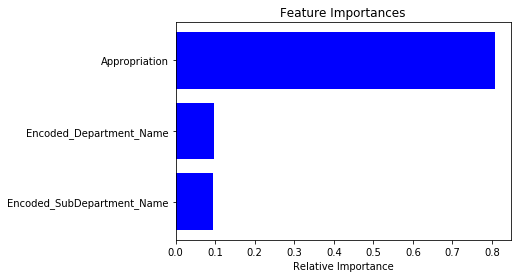

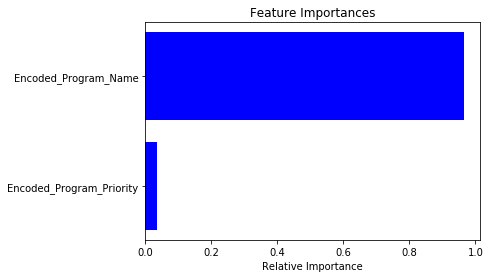

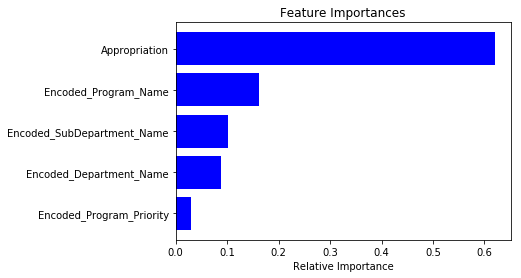

In [36]:
def plot_rfc_weights(forest, columns, fig_num=1):
    
    importances = forest.feature_importances_
    columns=np.array(columns)

    indices = np.argsort(importances)

    plt.figure(fig_num)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), columns[indices])
    plt.xlabel('Relative Importance')

    return

plot_rfc_weights(rfc_g, guaranteed, 1)
plot_rfc_weights(rfc_ng, not_guaranteed, 2)
plot_rfc_weights(rfc_all, all_keys, 3)

# TakeAway

So, unsurprisingly, the Appropriation ammmount is by far the most considered part of the data, followed by the program name. I'm gonna try to do some more work with the program name to extract more information from it later on

In [37]:
from sklearn import svm


def train_and_score_svc(data, iterations=1):
    
    train, cv = random_cv_split(full_data)
    
    svc_g = svm.SVC()
    svc_ng = svm.SVC()
    
    for i in range(iterations):

        svc_g.fit(train[guaranteed], train["Expense_Type"])
        score = svc_g.score(cv[guaranteed], cv["Expense_Type"])
        print("SVC guaranteed data Score: ", score)


        svc_ng.fit(train[guaranteed+not_guaranteed], train["Expense_Type"])
        score = svc_ng.score(cv[guaranteed+not_guaranteed], cv["Expense_Type"])
        print("SVC not guaranteed data Score: ", score)
    
    
    return svc_g, svc_ng

svc_g, svc_ng = train_and_score_svc(full_data)


SVC guaranteed data Score:  0.6745699674569967
SVC not guaranteed data Score:  0.6706183170618317


Not as good results as Random Forest, but it might scale better. With a smaller dataset I might use svm, but becasue we have around 80% of the data already filled and 20% not filled, I'm leaning towards the random forest

Also, SVM performs worse given the program name and ID, because it probably just adds unneccessary complexity towards the fitting.

# NLP

A major idea in NLP is the idea that word can be encoded into a vector space. Something interesting about this vector space, however, is that the difference in values (i.e. distance) between similar words and phrases will be smaller than the difference in values between dissimilar words. I'm going to try to leverage these encodings to see if there is a greater theme in either program priority or program names and the expense types

In [234]:
import gensim
from gensim.models import word2vec
import logging, urllib.request, zipfile

Download and load training data

# Train Gensim

We have to first train Gensim on data in order to load the word2vec of our data. These are some functions to read the zipfile, extract the zipfile, train gensim, and finally save the model under 'mymodel' so we don't have to retrain every time

I did packaged all this into a load_gensim_model function which takes in a root path to search for the data and model. If it finds the model it loads it, otherwise, it reads the data, trains the model, saves the model and returns the model. You can read the code in my utils.py file

In [19]:
model = load_gensim_model(os.getcwd()+"/data/")

Found and verified text8.zip


Since gensim only allows for word2vec, I need to make a module that can read a string of words and return the average of all the vectors

I then have another function that applies this sentence2vec function to an entire column of a pandas dataframe.

In [71]:
dim = 300

def sentence2vec(words):
    """
    Module that converts takes in a string 
    with multiple words, takes the word2vec
    of each word, and then averages them all
    to get a sentence to vec
    
    For this dataset, no tf-idf is needed
    because no word appears twice in a single sentance
    """
    
    avg_vec = np.array([
                    np.mean([model.wv[w] for w in words.split() if w in model.wv]
                            or [np.zeros(dim)], axis=0)
                ]).reshape([300])
    return avg_vec


def get_vector_column(column_name, keys, df):
    
    vector_keys = []
    
    for key in keys:

        vector_keys.append(sentence2vec(key))
    
    col = np.zeros( [df.shape[0], 300] )
    
    for i, key in enumerate(keys):
        index = df[column_name] == key
        
        index = index.values.reshape([df.shape[0], 1])
        
        
        index = np.repeat(index, 300, axis=1)
        
        np.place(col, index, vector_keys[i])
        
    return col


    

# More Data Preparations

Now, I want to prepare training data for a deep learning approach. My plan is to have 2 different models to train. 1 that only accepts the guaranteed information i.e. the department and the appropriation and tries to predict the expense type. Another that takes in the department, appropriation and the sentence vector describing the department. I have 2 functions below used to build up the corresponding datasets.

In [170]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    
def one_hot_Y(Y):
    
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(Y)
    
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded, label_encoder
    
def build_train_set(df, columns):
    
    #name_vectors = get_vector_column("Program_Name", programs, df)
    
    X_data = df[columns].values
    
    Y = df["Expense_Type"].values
    
    Y, decoder = one_hot_Y(Y)
    
    return name_vectors, X_data, Y, decoder
    

# Time Set up the Models

In [86]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Concatenate


# Start Slow

First I'm going to start out with a basic model that only accepts the guaranteed information. This will provide a good baseline for future models 

In [210]:
basic_model = Sequential()

in_shape = (2,)

basic_model.add(Dense(128, input_shape=in_shape, activation='relu' ))
basic_model.add(Dense(256, activation='relu'))
basic_model.add(Dense(len(expenses), activation='softmax'))

basic_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [218]:
name_vectors, train_data, Y, decoder = build_train_set(full_data, guaranteed)

basic_model.fit(train_data, Y, epochs=10)

Epoch 1/10
14243/14243 [==============================] - 1s 58us/step - loss: 1.1243 - acc: 0.5463
Epoch 2/10
14243/14243 [==============================] - 1s 56us/step - loss: 1.1367 - acc: 0.5478
Epoch 3/10
14243/14243 [==============================] - 1s 56us/step - loss: 1.1135 - acc: 0.5393
Epoch 4/10
14243/14243 [==============================] - 1s 56us/step - loss: 1.1139 - acc: 0.5403
Epoch 5/10
14243/14243 [==============================] - 1s 57us/step - loss: 1.0466 - acc: 0.5469
Epoch 6/10
14243/14243 [==============================] - 1s 56us/step - loss: 1.0984 - acc: 0.5486
Epoch 7/10
14243/14243 [==============================] - 1s 57us/step - loss: 1.0888 - acc: 0.5403
Epoch 8/10
14243/14243 [==============================] - 1s 58us/step - loss: 1.0974 - acc: 0.5527
Epoch 9/10
14243/14243 [==============================] - 1s 59us/step - loss: 1.2429 - acc: 0.5533
Epoch 10/10
14243/14243 [==============================] - 1s 57us/step - loss: 1.1169 - acc: 0.5375

# Takeaway

So unsurprisingly, the model can't even fit the training set much above 50%, much less a test set. I don't see much gain by hyper-parameter tinkering at this point. I think the route to take with the only guaranteed data filling in is just using the random forest. Now I'm gonna try out the non-guaranteed data sentance encoding to see if it helps much. I don't have great hopes, but it's worth a try :)

In [253]:
big_X = np.concatenate([train_data, name_vectors], axis=1)

bigger_model = Sequential()

in_shape = (302,)

bigger_model.add(Dense(128, input_shape=in_shape, activation='relu' ))
bigger_model.add(Dense(256, activation='relu'))
bigger_model.add(Dense(len(expenses), activation='softmax'))

bigger_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [254]:
bigger_model.fit(big_X, Y, epochs = 10)

Epoch 1/10
14243/14243 [==============================] - 1s 82us/step - loss: 7.6928 - acc: 0.4939
Epoch 2/10
14243/14243 [==============================] - 1s 75us/step - loss: 7.5460 - acc: 0.4979
Epoch 3/10
14243/14243 [==============================] - 1s 76us/step - loss: 7.4784 - acc: 0.4974
Epoch 4/10
14243/14243 [==============================] - 1s 76us/step - loss: 7.3967 - acc: 0.5059
Epoch 5/10
14243/14243 [==============================] - 1s 75us/step - loss: 7.2776 - acc: 0.5022
Epoch 6/10
14243/14243 [==============================] - 1s 77us/step - loss: 6.9535 - acc: 0.5056
Epoch 7/10
14243/14243 [==============================] - 1s 78us/step - loss: 1.8774 - acc: 0.5119
Epoch 8/10
14243/14243 [==============================] - 1s 78us/step - loss: 1.5324 - acc: 0.5181
Epoch 9/10
14243/14243 [==============================] - 1s 77us/step - loss: 1.6682 - acc: 0.5278
Epoch 10/10
14243/14243 [==============================] - 1s 78us/step - loss: 1.2556 - acc: 0.5357

# Last DL Effort

So the last few efforts didn't go very well, so I'm gonna try 1 more task. I'm gonna try to run the word encodings through a FC encoder, then concatenate that with the other data, and then make a prediction

But, given the small sample size and wide variety of uncorrelated inputs, I didn't think this was a problem well suited for deep learning. I was more interested in whether the vectorization of the sentences would show any improvements over the baseline but it did not seem to

In [320]:
vec = Input(shape=(300,))

enc1 = Dense(128, activation='relu')(vec)
enc2 = Dense(64, activation='relu')(enc1)
enc3 = Dense(5, activation='relu')(enc2)

data = Input(shape=(2,))

full_data = Concatenate()([vec, data])

fc1 = Dense(64, activation='relu')(full_data)
fc2 = Dense(128, activation='relu')(fc1)
output = Dense(len(expenses), activation='softmax')(fc2)

final_model = Model([vec, data], output)

final_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [321]:
final_model.fit([name_vectors, train_data], Y, epochs=10)

Epoch 1/10
14243/14243 [==============================] - 1s 63us/step - loss: 7.7375 - acc: 0.4858
Epoch 2/10
14243/14243 [==============================] - 1s 52us/step - loss: 7.6900 - acc: 0.4934
Epoch 3/10
14243/14243 [==============================] - 1s 52us/step - loss: 7.5510 - acc: 0.4992
Epoch 4/10
14243/14243 [==============================] - 1s 53us/step - loss: 7.6876 - acc: 0.4944
Epoch 5/10
14243/14243 [==============================] - 1s 54us/step - loss: 7.6477 - acc: 0.4936
Epoch 6/10
14243/14243 [==============================] - 1s 54us/step - loss: 7.4674 - acc: 0.5035
Epoch 7/10
14243/14243 [==============================] - 1s 55us/step - loss: 7.4139 - acc: 0.4976
Epoch 8/10
14243/14243 [==============================] - 1s 55us/step - loss: 7.0525 - acc: 0.5082
Epoch 9/10
14243/14243 [==============================] - 1s 57us/step - loss: 2.9391 - acc: 0.5119
Epoch 10/10
14243/14243 [==============================] - 1s 58us/step - loss: 1.2222 - acc: 0.5205

# Done with the Dirty Digging

I'm going to now move my stuff over to a clean notebook and try to work through some final results